In [1]:
import os
import platform
from os import path as osp

import matplotlib.pyplot as plt
import numpy as np
from numpy import nanmean
import pandas as pd
import yaml

plt.rcParams['figure.facecolor'] = 'white'

In [2]:
if 'g2' in platform.node() or 'compute' in platform.node() or 'cpu' in platform.node():
    repo_dir = '/share/kuleshov/yzs2/TNP-pytorch/'
else:
    repo_dir = '/Users/yairschiff/Development/TNP-pytorch/'

In [3]:
exp_category = 'regression'
exp = 'celeba'
resize = 64
max_num_ctx = [8, 16, 32, 64, 128, 256, 512, 1024]
models = ['anp', 'banp', 'canp', 'ipcanp', 'ipanp']

In [4]:
# Read hyperparams and results
args_file = 'args.yaml'
config_file = 'config.yaml'
eval_file = 'eval.log'
timing_file = 'timing.log'
exp_list = []
for maxc in max_num_ctx:
    for minc in [maxc // 2]: #min_num_ctx:
        results_dir = osp.join(repo_dir, exp_category, 'results',
                               f'{exp}', f'{resize}x{resize}', f'ctx-{minc}-{maxc}_tar-all')
        if not osp.exists(results_dir):
            continue
        for m in models:
            if not osp.exists(osp.join(results_dir, m)):
                continue
            for v in os.listdir(osp.join(results_dir, m)):
                if 'bak' in v:
                    continue
                exp_dict = {}
                # Parse args yaml:
                try:
                    with open(osp.join(results_dir, m, v, args_file), 'r') as af:
                        try:
                            exp_dict = yaml.safe_load(af)
                        except yaml.YAMLError as exc:
                            print(exc)
                except FileNotFoundError as fe:
                    print(fe)
                # Parse timing
                timing_dict = {}
                try:
                    with open(osp.join(results_dir, m, v, timing_file), 'r') as ef:
                        for line in ef.readlines():
                            line_split = line.strip().split()
                            timing_dict[f'{line_split[0].lower()}_time'] = line_split[-1]
                    exp_dict.update(timing_dict)
                except FileNotFoundError as fe:
                    print(fe)
                # Parse eval
                eval_dict = {}
                try:
                    with open(osp.join(results_dir, m, v, eval_file), 'r') as ef:
                        for line in ef.readlines():
                            line_split = line.split()
                            tar_idx = line_split.index('tar_ll')
                            eval_dict[line_split[tar_idx]] = line_split[tar_idx+1]
                    exp_dict.update(eval_dict)
                except FileNotFoundError as fe:
                    print(fe)
                exp_list.append(exp_dict)
exp_df = pd.DataFrame(exp_list).rename(columns={'tar_ll': 'eval_ll'}).dropna(subset=['model'])
exp_df = exp_df.astype({'eval_ll': 'float', 'avg_time': 'float', 'total_time': 'float'})
exp_df['avg_time'] = exp_df['avg_time']*1000
#(sorted(exp_list, key=lambda x: f'{x["model"]}-{x["expid"]}'))

[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/celeba/64x64/ctx-8-16_tar-all/anp/v0/timing.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/celeba/64x64/ctx-8-16_tar-all/anp/v0/eval.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/celeba/64x64/ctx-16-32_tar-all/anp/v0/timing.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/celeba/64x64/ctx-16-32_tar-all/anp/v0/eval.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/celeba/64x64/ctx-32-64_tar-all/anp/v0/timing.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/celeba/64x64/ctx-32-64_tar-all/anp/v0/eval.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/celeba/64x64/ctx-32-64_tar-all/anp/v1/timing.log'
[Errno 2] No such file or di

In [5]:
cols = ['model', 'expid', 
        'min_num_ctx', 'max_num_ctx',
        'eval_ll', 'total_time', 'avg_time']
exp_df_for_fig_unagg = exp_df[cols].sort_values(by=['min_num_ctx', 'model', 'expid'])
exp_df_for_fig = exp_df_for_fig_unagg
# exp_df_for_fig = exp_df_for_fig_unagg.groupby(['model', 'min_num_ctx'], as_index=False).agg({
#     'eval_ll': ['mean','std'],
#     'total_time': ['mean','std'],
#     'avg_time': ['mean','std'],
#     'min_num_ctx': ['first', 'count'],
#     'max_num_ctx': 'first'
# })
display(exp_df_for_fig)

,model,expid,min_num_ctx,max_num_ctx,eval_ll,total_time,avg_time
0,anp,v0,8,16,NaN,NaN,NaN
1,banp,v0,8,16,2.3074,153287.763479,766438.817397
2,canp,v0,8,16,1.2516,30143.213574,150716.067868
4,ipanp,v0,8,16,1.7257,58119.595376,290597.976880
3,ipcanp,v0,8,16,1.1800,28881.892848,144409.464241
5,anp,v0,16,32,NaN,NaN,NaN
6,banp,v0,16,32,2.6338,159040.021297,795200.106485
7,canp,v0,16,32,1.8003,30555.500079,152777.500395
9,ipanp,v0,16,32,2.1182,58964.486197,294822.430986
8,ipcanp,v0,16,32,1.7089,27773.098681,138865.493407


In [6]:
# model_for_table = {'anp': 'ANP', 'banp': 'BANP', 'canp': 'CANP', 'ipcanp': 'CIPNP', 'ipanp': 'IPNP'}
# print('& \\multicolumn{5}{c}{\\textit{Context size range}}\\\\')
# print(' '.join([f'& [{maxc//2}, {maxc}]' for maxc in max_num_ctx]) + '\\\\')
# print('\\midrule')
# for m in models:
#     print('\\multirow[t]{2}{*}{' + model_for_table[m] + '}', end='')
#     for maxc in max_num_ctx:
#         max_eval_ll = exp_df_for_fig[exp_df_for_fig['max_num_ctx'] == maxc]['eval_ll'].max()
#         print(' &', end=' ')
#         eval_ll = exp_df_for_fig[(exp_df_for_fig['model'] == m) &
#                                  (exp_df_for_fig['max_num_ctx']==maxc)]['eval_ll'].item()
#         if np.isnan(eval_ll):
#             print('\\multirow[c]{2}{*}{OOM}', end='')
#         else:
#             if eval_ll == max_eval_ll:
#                 print('\\bf', end='')
#             print(f'{eval_ll:.3f}', end='')
#     print('\\\\\n', end='')
#     for maxc in max_num_ctx:
#         min_time = exp_df_for_fig[exp_df_for_fig['max_num_ctx'] == maxc]['total_time'].min()
#         print(' &', end=' ')
#         time = exp_df_for_fig[(exp_df_for_fig["model"]==m) &
#                                  (exp_df_for_fig["max_num_ctx"]==maxc)]["total_time"].item()
#         if not np.isnan(time):
#             if time == min_time:
#                 print('\\bf', end='')
#             print(f'{time:.2f}', end='')
#     print('\\\\\n\\midrule\n', end='')

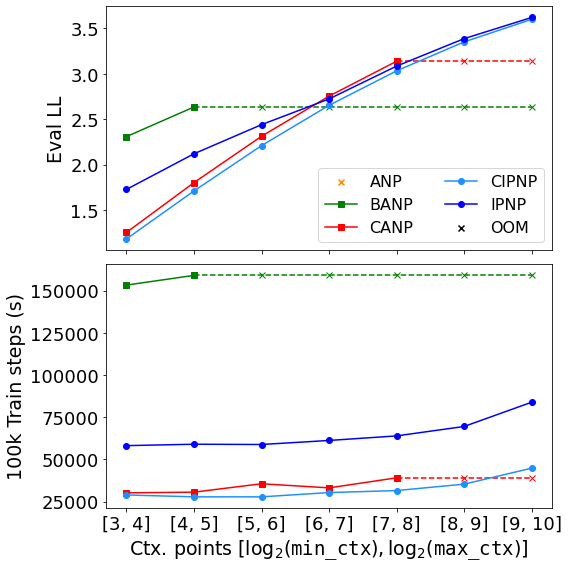

In [9]:
model_display_name = {'anp': 'ANP', 'banp': 'BANP', 'canp': 'CANP', 'ipcanp': 'CIPNP', 'ipanp': 'IPNP'}
colors = {'anp': 'darkorange', 'banp': 'green', 'canp': 'red', 'ipcanp': 'dodgerblue', 'ipanp': 'blue'}

x_label = r'Ctx. points $[\log_2(\mathtt{min\_ctx}), \log_2(\mathtt{max\_ctx})]$'
# min_num_ctx = np.log2(np.array(exp_df_for_fig['min_num_ctx']['first'].unique()))
# max_num_ctx = np.log2(np.array(exp_df_for_fig['max_num_ctx']['first'].unique()))
min_num_ctx = np.log2(np.array(exp_df_for_fig['min_num_ctx'].unique()))
max_num_ctx = np.log2(np.array(exp_df_for_fig['max_num_ctx'].unique()))

nan_found = False
fig, ax = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(8, 8))
for m in models:
#     eval_ll_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m ]['eval_ll']['mean'])
#     eval_ll_std = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['eval_ll']['std'])
#     time_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['avg_time']['mean'])
#     time_std = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['avg_time']['std'])
    eval_ll_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m ]['eval_ll'])
    time_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['total_time'])
    # If everything is NaN then model should have zero everything
    if np.isnan(eval_ll_mean).sum() == eval_ll_mean.shape[0]:
        ax[0].scatter([], [], marker='x', color=colors[m], label=model_display_name[m])
    else:
        ax[0].plot(min_num_ctx[~np.isnan(eval_ll_mean)],
                   eval_ll_mean[~np.isnan(eval_ll_mean)],
                   label=model_display_name[m],
                   marker=('o' if 'ip' in m else 's'),
                   color=colors[m])
        if np.isnan(eval_ll_mean).sum():
            nan_found = True
            ax[0].plot(np.concatenate([min_num_ctx[~np.isnan(eval_ll_mean)][-1:],
                                       min_num_ctx[np.isnan(eval_ll_mean)]]),
                       np.repeat([eval_ll_mean[~np.isnan(eval_ll_mean)][-1:]], np.isnan(eval_ll_mean).sum()+1),
                       linestyle='--',
                       marker='x',
                       color=colors[m])
#         ax[0].fill_between(min_num_ctx, eval_ll_mean-eval_ll_std, eval_ll_mean+eval_ll_std,
#                            color=colors[m],
#                            alpha = 0.2)
    
    # If everything is NaN then model should have zero everything
    if np.isnan(time_mean).sum() == time_mean.shape[0]:
        ax[1].scatter([], [], marker='x', color=colors[m], label=model_display_name[m])
    else:
        ax[1].plot(min_num_ctx[~np.isnan(time_mean)],
                   time_mean[~np.isnan(time_mean)],
                   label=model_display_name[m],
                   marker=('o' if 'ip' in m else 's'),
                   color=colors[m])
        if np.isnan(time_mean).sum():
            nan_found = True
            ax[1].plot(np.concatenate([min_num_ctx[~np.isnan(time_mean)][-1:],
                                       min_num_ctx[np.isnan(time_mean)]]),
                       np.repeat([time_mean[~np.isnan(time_mean)][-1:]], np.isnan(time_mean).sum()+1),
                       linestyle='--',
                       marker='x',
                       color=colors[m])
#         ax[1].fill_between(min_num_ctx, time_mean-time_std, time_mean+time_std,
#                            color=colors[m],
#                            alpha = 0.2)
    

if nan_found:
    ax[0].scatter([], [], marker='x', color='black', label='OOM')
    ax[1].scatter([], [], marker='x', color='black', label='OOM')
# 
ax[0].legend(loc='lower right', ncol=2, fontsize=16)
# ax[0].set_xticks(ticks=min_num_ctx, labels=[f'[{int(minc):d}, {int(maxc):d}]'
#                                             for minc, maxc in zip (min_num_ctx, max_num_ctx)])
# ax[0].set_xlabel(x_label)
ax[0].set_ylabel('Eval LL', fontsize=19)
ax[0].tick_params(axis='y', labelsize=18)

# ax[1].legend(loc='best', fontsize=15.5)
ax[1].set_ylabel('100k Train steps (s)', fontsize=19)
ax[1].tick_params(axis='y', labelsize=18)
ax[1].set_xlabel(x_label, fontsize=19)
ax[1].set_xticks(ticks=min_num_ctx,
                 labels=[f'[{int(minc):d}, {int(maxc):d}]'
                         for minc, maxc in zip(min_num_ctx, max_num_ctx)],
                 fontsize=18)
plt.show()
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'{resize}x{resize}', 'NP_celeba.pdf'))
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'{resize}x{resize}', 'NP_celeba.svg'))